In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import math                             # Added the math lib for math.isnan()

titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [3]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [4]:
# Fill missing values in 'age' with the average age
from sklearn.model_selection import train_test_split

mean_age = 0    # sum of ages
i = 0           # Number of valid ages
for age in titanic["age"]:
    age = float(age)
    if not(math.isnan(age)):
        mean_age += age
        i += 1
mean_age = mean_age/i

for index, row in titanic.iterrows():
    # Replace NaNs
    if math.isnan(row["age"]):
        titanic.loc[index, "age"] = mean_age

    # Check if equal to 1 or 0
                                                   
# Discretization
INDEPENDENT_VARIABLES = ["pclass",
                         "sex",
                         "age",
                         "sibsp"]
DEPENDENT_VARIABLE = "survived"
x_data = titanic.loc[:, INDEPENDENT_VARIABLES]
y_data = titanic.loc[:, DEPENDENT_VARIABLE]


# Split the data into 80% training and 20% test sets
x_training, x_testing, y_training, y_testing = train_test_split(
    x_data,
    y_data,
    test_size = 0.2
)

The most important stage of this section is filling in any gaps in the "age" attribute. Therefore, all present ages are added up and divided to find the average of a passenger. Any blanks are filled with this information.
Since age is continuous, the `QuantileBinning()` method is called to split the ages into 10 distinct "bins." Data is further segmented into x_training, x_testing, y_training, y_testing using an 80/20 split. This is accomplished though the `train_test_split()` method.

# Step 2

In [5]:
### Implementing quantile binning ###
NUM_BINS = 10
x_training["age"] = QuantileBinning(x_training["age"], NUM_BINS)
x_testing["age"] = QuantileBinning(x_testing["age"], NUM_BINS)

# define your entropy function and information gain function
def calc_entropy(x_data, y_data):
    total_samples = len(x_data)
    value_vec = x_data.unique()
    temp_df = pd.concat([x_data, y_data], 
                        axis=1,
                        keys=["x_data","y_data"])
    entropy_vec = []
    for novel_value in value_vec:
        p = 0
        n = 0
        t = 0
        for index, row in temp_df.iterrows():
            if row["x_data"] == novel_value:
                if row["y_data"] == 1:
                    p += 1
                else:
                    n += 1
                t += 1
        entropy_vec.append(
            (t/total_samples) * ((-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t))
        )
    
    return sum(entropy_vec)

p = y_training.value_counts()[1]
n = y_training.value_counts()[0]
t = len(y_training)
baseline = (-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t)
info_gains = {}
for attribute in INDEPENDENT_VARIABLES:
    this_entropy = calc_entropy(x_training[attribute], y_training)
    info_gains[attribute] = baseline - this_entropy

print(info_gains)


{'pclass': 0.07318397527713105, 'sex': 0.22133831862380615, 'age': 0.02301859941624973, 'sibsp': nan}


C:\Users\camer\AppData\Local\Temp\ipykernel_29364\2195671806.py:26: RuntimeWarning: divide by zero encountered in log2
  (t/total_samples) * ((-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t))
C:\Users\camer\AppData\Local\Temp\ipykernel_29364\2195671806.py:26: RuntimeWarning: invalid value encountered in double_scalars
  (t/total_samples) * ((-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t))


Entropy is calculated in this step as defined in slide 8 of lecture 4. Entropy for each value in each attribute is calculated, then the individual entropies for each attribute are summed. Finally, each attribute is compared to find the best parameters.
Unfortunently, I ran into a divide by 0 error for the sibsp attribute. I assume that this is due to some bad data formatting, but I ran out of time to debug it properly. All other values seem to be in line though.

# Step 3

[Text(168.2048076923077, 201.90857142857143, 'X[0] <= 0.5\ngini = 0.475\nsamples = 1047\nvalue = [641, 406]'),
 Text(83.16346153846153, 170.84571428571428, 'X[1] <= 0.5\ngini = 0.299\nsamples = 657\nvalue = [537, 120]'),
 Text(40.776923076923076, 139.78285714285715, 'X[3] <= 6.5\ngini = 0.443\nsamples = 139\nvalue = [93, 46]'),
 Text(19.315384615384616, 108.72, 'X[3] <= 0.5\ngini = 0.49\nsamples = 79\nvalue = [45, 34]'),
 Text(8.584615384615384, 77.65714285714284, 'X[2] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(4.292307692307692, 46.59428571428572, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(12.876923076923077, 46.59428571428572, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(30.046153846153846, 77.65714285714284, 'X[3] <= 2.5\ngini = 0.482\nsamples = 74\nvalue = [44, 30]'),
 Text(21.46153846153846, 46.59428571428572, 'X[2] <= 0.5\ngini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(17.16923076923077, 15.531428571428563, 'gini = 0.408\nsamples = 7\nvalue = [5

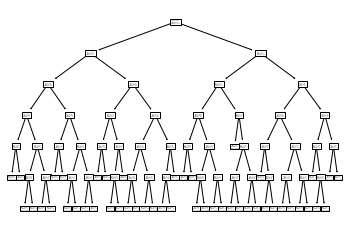

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!

# Instantiate the DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(max_depth=6)

# Prepare the features and target variables for training
# Values in "sex" and "pclass" need to be replaced w floats
                   
feature_list = pd.concat([x_training["sex"].replace({"male": 0,
                                                    "female": 1}),
                          x_training["pclass"].replace({"1st":0,
                          "2nd":1,
                          "3rd":2}),
                          x_training["sibsp"],
                          x_training["age"]],
                          axis=1
)

# Fit the decision tree model
tree_classifier.fit(feature_list.values,
                    y_training)

# Plot the full decision tree
plot_tree(tree_classifier)


Finally, we arrive at the actual decision tree generator. Each feature is concatinated into one dataframe, in order of importance as defined in step 3. This dataframe is given to an object that was returned by the `DecisionTreeClassifier()` method. Calling `fit()` will train the model

In [7]:
# Define your performance metrics including accuracy, precision, recall and F1-score

def test_tree(x_testing, y_testing, model):
    # Pass in test datasets for x and y as well as the trained model
    # Return precision, recall, F1 score
    # Some definitions upfront
    positive = 1    # Value of a Positive
    negative = 0    # Value of a Negative
    TP = 0          # Num. of true positives
    TN = 0          # Num. of true negatives
    FP = 0          # Num. of false positives
    FN = 0          # Num. of false negatives

    for index, row in x_testing.iterrows():
        prediction = model.predict([row.values])
        if prediction == y_testing[index] == positive:
            TP += 1
        elif prediction == y_testing[index] == negative:
            TN += 1
        else:
            if y_testing[index] == positive:
                FN += 1
            elif y_testing[index] == negative:
                FP += 1

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*(precision * recall)/(precision + recall)
    return precision, recall, F1

feature_list_testing = pd.concat([x_testing["sex"].replace({"male": 0,
                                                    "female": 1}),
                          x_testing["pclass"].replace({"1st":0,
                          "2nd":1,
                          "3rd":2}),
                          x_testing["sibsp"],
                          x_testing["age"]],
                          axis=1
                        )

print(test_tree(feature_list_testing, y_testing, tree_classifier))


(0.72, 0.574468085106383, 0.6390532544378699)


The performance of the model can be evaluated by using a custom function called `test_tree()`, which finds the number of true positive, true negative, false positive, and false negative values and determines the precision, recall, and F1 scores of the model, which are then printed.

# Step 4

(0.7432432432432432, 0.5851063829787234, 0.6547619047619048)


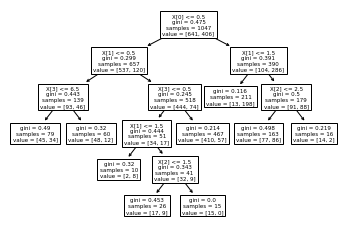

In [8]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
def train_model(x_training, y_training, param_grid):
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
    grid_search.fit(x_training.values, y_training) # Note testing set cannot be used
    return grid_search.best_estimator_

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = train_model(feature_list, y_training, param_grid)

# Plot the pruned decision tree
plot_tree(best_tree)
print(test_tree(feature_list_testing, y_testing, best_tree))

Similar to step 3, though here we use a `GridSearchCV()` instead of a `DecisionTreeClassifier()`. Performance metrics are calculated using the same `test_tree()` function

# Step 5


In [14]:
def ensemble_vote(models, x_testing, y_testing):
    # I know this is horribly unoptimized
    positive = 1    # Value of a Positive
    negative = 0    # Value of a Negative
    TP = 0          # Num. of true positives
    TN = 0          # Num. of true negatives
    FP = 0          # Num. of false positives
    FN = 0          # Num. of false negatives

    for index, row in x_testing.iterrows():
        temp = []
        for model in models:
            temp.append(model.predict([row.values]))
        prediction = max(set(temp[0]), key=temp.count)  # Funky indexing stuff
        if prediction == y_testing[index] == positive:
            TP += 1
        elif prediction == y_testing[index] == negative:
            TN += 1
        else:
            if y_testing[index] == positive:
                FN += 1
            elif y_testing[index] == negative:
                FP += 1

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*(precision * recall)/(precision + recall)
    return precision, recall, F1


# Use the defined function to get predictions from the ensemble of the three trees

param_grid = {'max_leaf_nodes': list(range(5, 20)),
                "max_depth": list(range(1,10))}

dt_max_depth = train_model(feature_list, y_training, param_grid)

param_grid = {'max_leaf_nodes': list(range(5, 20)),
                "min_samples_split": [2,3,4]}

dt_opt_critia = train_model(feature_list, y_training, param_grid)

models = [best_tree, dt_max_depth, dt_opt_critia]

# Calculate performance metrics for the ensemble using the previously defined function
print(ensemble_vote(models, feature_list_testing, y_testing))


(0.7432432432432432, 0.5851063829787234, 0.6547619047619048)


The ensemble is generated by returning different models, trained by providing different metrics for `param_grid`. These are fed into the `ensemble_vote()` method, which is basically a derivative of the `test_tree()` method. The only exception is the slight difference in determining the prediction; in this case, the most common element of the predictions is determined to be the final prediction. 
The rest of the evaluation scheme is the same as the `test_tree()` method